In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Importing the Libraries.
import keras
import os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
#import keras.backend as K
import tensorflow.keras.backend as K
import tensorflow.compat.v1 as tf
from os import listdir
from os.path import isfile, join
import numpy as np
import sys
import os
import shutil
import pandas as pd
from PIL import Image
import cv2
import keras
import glob
from PIL import Image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPool2D
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.models import load_model
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from PIL import ImageFile

tf.enable_eager_execution()

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# Data Augmentation.
DataGenerator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rescale=1./255, brightness_range=[0.2,0.7])

In [ ]:
TestGenerator = ImageDataGenerator(rescale=1./255)

In [ ]:
Grey_TrainingData = DataGenerator.flow_from_directory('/content/drive/My Drive/KTH-Colour/Train-dataset/', target_size=(224,224), batch_size=8, color_mode='grayscale')

Found 2868 images belonging to 11 classes.


In [ ]:
Grey_ValidData = TestGenerator.flow_from_directory('/content/drive/My Drive/KTH-Colour/valid/', target_size=(224,224),batch_size=8, color_mode='grayscale')

Found 161 images belonging to 11 classes.


In [ ]:
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [ ]:
from keras.applications import ResNet50

In [ ]:
# Convoluted Base Model.
conv_base = ResNet50(weights='imagenet', include_top=False)

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
# Make last block of the conv_base trainable:

for layer in conv_base.layers[:165]:
   layer.trainable = False
for layer in conv_base.layers[165:]:
   layer.trainable = True
for layer in conv_base.layers:
  if isinstance(layer, BatchNormalization):
    layer.trainable = True

In [ ]:
model = Sequential()

In [ ]:
from keras.layers import Input 

In [ ]:
input_tensor = Input(shape=(224,224,1))
x = Conv2D(3,(3,3), padding='same')(input_tensor)
out = conv_base(x)

In [ ]:
models = Model(inputs = input_tensor, outputs = out)

In [ ]:
model.add(models)

In [ ]:
# Adding layers.
model.add(Flatten())
model.add(Dense(2048, activation='relu', kernel_regularizer= regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(11, activation='softmax'))

In [ ]:
from keras.optimizers import Adam

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("/content/drive/My Drive/KTH-Colour/Resnet_50_GrayScale.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 50,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 50,
                              verbose = 1,
                              min_delta = 0.00001)

callBacks = [earlystop, checkpoint, reduce_lr]

In [ ]:
hist = model.fit_generator(steps_per_epoch=359,generator= Grey_TrainingData, validation_data= Grey_ValidData, validation_steps=20,epochs=150,callbacks=callBacks)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/150
359/359 [==============================] - ETA: 0s - loss: 18.4297 - accuracy: 0.6834
Epoch 00001: val_loss improved from inf to 235.43396, saving model to /content/drive/My Drive/KTH-Colour/Resnet_50_GrayScale.h5
359/359 [==============================] - 1372s 4s/step - loss: 18.4297 - accuracy: 0.6834 - val_loss: 235.4340 - val_accuracy: 0.0188
Epoch 2/150
359/359 [==============================] - ETA: 0s - loss: 8.5572 - accuracy: 0.7918
Epoch 00002: val_loss did not improve from 235.43396
359/359 [==============================] - 51s 143ms/step - loss: 8.5572 - accuracy: 0.7918 - val_loss: 523.6974 - val_accuracy: 0.1125
Epoch 3/150
359/359 [==============================] - ETA: 0s - loss: 7.5275 - accuracy: 0.8358
Epoch 00003: val_loss improved from 235.43396 to 48.81634, saving model to /content/drive/My Drive/KTH-Colour/Resnet_50_GrayScale.h5
359/359 [==============================] - 55s

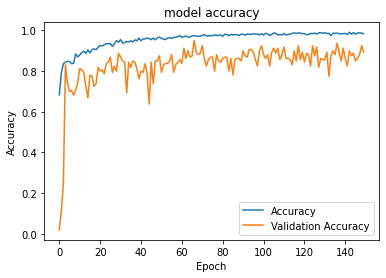

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

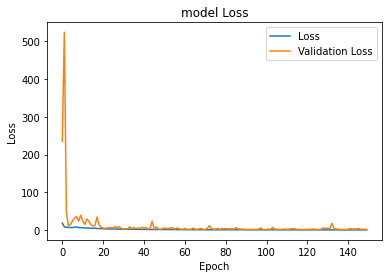

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

In [ ]:
GreyTestData = TestGenerator.flow_from_directory('/content/drive/My Drive/KTH-Colour/Test/', target_size=(224,224), batch_size = 8, shuffle = False, color_mode='grayscale')

Found 166 images belonging to 11 classes.


In [ ]:
Grey_predict = model.predict(GreyTestData)

In [ ]:
Grey_predict_classes = np.argmax(Grey_predict, axis=1)

In [ ]:
Grey_predict_classes

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  3,  3,  3,  3,  3,  3,  3,  4,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  4,  3,  3,  3,  3,  4,  4,  0,  0,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  4,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  4,  6,  6,  0,  6,  4,  6,  7,  7,  7,  8,  8,
        8,  8,  8,  9,  9,  9,  9,  9, 10, 10,  4,  4, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

In [ ]:
Grey_accuracy = accuracy_score(GreyTestData.classes, Grey_predict_classes)
print("Grey Accuracy: ", Grey_accuracy)

Grey Accuracy:  0.9397590361445783


In [ ]:
Grey_precision = precision_score(GreyTestData.classes, Grey_predict_classes,average="weighted")
print("Grey Precision: ", Grey_precision)

Grey Precision:  0.9487291099883405


In [ ]:
Grey_recall = recall_score(GreyTestData.classes, Grey_predict_classes, average="weighted")
print("Grey Recall:", Grey_recall)

Grey Recall: 0.9397590361445783


In [ ]:
Grey_f1_score = f1_score(GreyTestData.classes, Grey_predict_classes, average="weighted")
print("F1 score for Grey: ", Grey_f1_score)

F1 score for Grey:  0.941136004584648


In [ ]:
Colour_TrainingData =  DataGenerator.flow_from_directory('/content/drive/My Drive/KTH-Colour/Train-dataset/', target_size=(224,224), batch_size=8)

Found 2868 images belonging to 11 classes.


In [ ]:
Colour_ValidData =  DataGenerator.flow_from_directory('/content/drive/My Drive/KTH-Colour/valid/', target_size=(224,224), batch_size=8)

Found 161 images belonging to 11 classes.


In [ ]:
# Convoluted Base Model.
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [ ]:
# Make last block of the conv_base trainable:

for layer in conv_base.layers[:165]:
   layer.trainable = False
for layer in conv_base.layers[165:]:
   layer.trainable = True
for layer in conv_base.layers:
  if isinstance(layer, BatchNormalization):
    layer.trainable = True


In [ ]:
colour_model = Sequential()

In [ ]:
colour_model.add(conv_base)

In [ ]:
# Adding layers.
colour_model.add(Flatten())
colour_model.add(Dense(2048, activation='relu', kernel_regularizer= regularizers.l2(0.001)))
colour_model.add(Dropout(0.5))
colour_model.add(Dense(11, activation='softmax'))

In [ ]:
from keras.optimizers import Adam

In [ ]:
colour_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("/content/drive/My Drive/KTH-Colour/Resnet_Colour.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 50,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 50,
                              verbose = 1,
                              min_delta = 0.00001)

callBacks = [earlystop, checkpoint, reduce_lr]

In [ ]:
hist = colour_model.fit_generator(steps_per_epoch=359,generator= Colour_TrainingData, validation_data= Colour_ValidData, validation_steps=20,epochs=150,callbacks=callBacks)

Epoch 1/150
359/359 [==============================] - ETA: 0s - loss: 16.0971 - accuracy: 0.7200
Epoch 00001: val_loss improved from inf to 719.38306, saving model to /content/drive/My Drive/KTH-Colour/Resnet_Colour.h5
359/359 [==============================] - 54s 150ms/step - loss: 16.0971 - accuracy: 0.7200 - val_loss: 719.3831 - val_accuracy: 0.0250
Epoch 2/150
359/359 [==============================] - ETA: 0s - loss: 10.0849 - accuracy: 0.8504
Epoch 00002: val_loss improved from 719.38306 to 201.98560, saving model to /content/drive/My Drive/KTH-Colour/Resnet_Colour.h5
359/359 [==============================] - 82s 229ms/step - loss: 10.0849 - accuracy: 0.8504 - val_loss: 201.9856 - val_accuracy: 0.1625
Epoch 3/150
359/359 [==============================] - ETA: 0s - loss: 9.2983 - accuracy: 0.8699
Epoch 00003: val_loss improved from 201.98560 to 13.85450, saving model to /content/drive/My Drive/KTH-Colour/Resnet_Colour.h5
359/359 [==============================] - 73s 204ms/ste

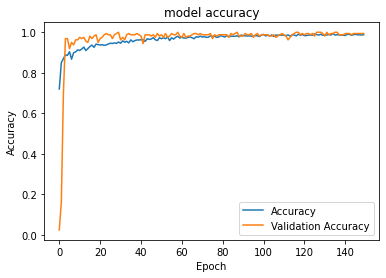

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

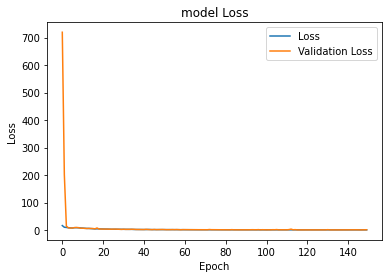

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

In [ ]:
Colour_TestData = TestGenerator.flow_from_directory('/content/drive/My Drive/KTH-Colour/Test/', target_size=(224,224), batch_size = 8, shuffle = False)

Found 166 images belonging to 11 classes.


In [ ]:
Colour_predict = colour_model.predict(Colour_TestData)

In [ ]:
Colour_predict_classes = np.argmax(Colour_predict, axis=1)

In [ ]:
Colour_predict_classes

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
        0,  6,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  7,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  4,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  0,  0,  6,  6,  6,  6,  6,  7,  7,  7,  8,  8,
        8,  8,  8,  9,  9,  9,  4,  9, 10, 10, 10,  6, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

In [ ]:
Colour_accuracy = accuracy_score(Colour_TestData.classes, Colour_predict_classes)
print("Colour Accuracy: ", Colour_accuracy)

Colour Accuracy:  0.9518072289156626


In [ ]:
Colour_precision = precision_score(Colour_TestData.classes, Colour_predict_classes,average="weighted")
print("Colour Precision: ", Colour_precision)

Colour Precision:  0.9546959265633964


In [ ]:
Colour_recall = recall_score(Colour_TestData.classes, Colour_predict_classes, average="weighted")
print("Colour Recall:", Colour_recall)

Colour Recall: 0.9518072289156626


In [ ]:
Colour_f1_score = f1_score(Colour_TestData.classes, Colour_predict_classes, average="weighted")
print("F1 score for colour: ", Colour_f1_score)

F1 score for colour:  0.9519753804938319


In [ ]:
Final = 0.6* Colour_predict + 0.4* Grey_predict

In [ ]:
Final_Predict_classes = np.argmax(Final, axis=1)

In [ ]:
Final_accuracy = accuracy_score(Colour_TestData.classes, Final_Predict_classes)
print("Colour Accuracy: ", Final_accuracy)

Colour Accuracy:  0.963855421686747


In [ ]:
Final_precision = precision_score(Colour_TestData.classes, Final_Predict_classes,average="weighted")
print("Colour Precision: ", Final_precision)

Colour Precision:  0.9672528193734458


In [ ]:
Final_recall = recall_score(Colour_TestData.classes, Final_Predict_classes, average="weighted")
print("Colour Recall:", Final_recall)

Colour Recall: 0.963855421686747


In [ ]:
Final_f1_score = f1_score(Colour_TestData.classes, Final_Predict_classes, average="weighted")
print("F1 score for colour: ", Final_f1_score)

F1 score for colour:  0.9638649750806018


In [ ]:
Second_final = 0.5* Colour_predict + 0.5* Grey_predict

In [ ]:
Second_Final_Predict_classes = np.argmax(Second_final, axis=1)

In [ ]:
Mean_Final_accuracy = accuracy_score(Colour_TestData.classes, Second_Final_Predict_classes)
print("Colour Accuracy: ", Mean_Final_accuracy)

Colour Accuracy:  0.9759036144578314


In [ ]:
Mean_Precision = precision_score(Colour_TestData.classes, Second_Final_Predict_classes, average="weighted")
Mean_Precision

0.9773538598839803

In [ ]:
Mean_Recall = recall_score(Colour_TestData.classes, Second_Final_Predict_classes, average="weighted")
Mean_Recall

0.9759036144578314

In [ ]:
Mean_F1Score = f1_score(Colour_TestData.classes, Second_Final_Predict_classes, average="weighted")
Mean_F1Score

0.976025013498104